In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier

# Constants
from dlomix.constants import ALPHABET_UNMOD

# Baselines

## Data Preprocessing

The data preprocessing involves loading sequences, removing modifications, encoding sequences using a predefined alphabet, and padding them to a uniform length.


In [2]:
# Load and preprocess data
def preprocess_data(file_path):
    """Load data, remove specific sequences, encode, and pad sequences to uniform length."""
    data = pd.read_parquet(file_path)
    # Removing sequences containing 'UNIMOD'
    data = data[~data.modified_sequence.str.contains('UNIMOD')]
    # Encoding sequences
    data['encoded_sequences'] = data.modified_sequence.apply(list).apply(
        lambda x: np.array([ALPHABET_UNMOD[aa] for aa in x], dtype=int))
    max_len = data.encoded_sequences.apply(len).max()
    # Padding sequences
    data.encoded_sequences = data.encoded_sequences.apply(
        lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))
    return data, max_len

In [3]:
processed_data, max_sequence_length = preprocess_data("/mnt/c/Users/Florian/Desktop/Uni/MSc/FoPr/preprocessed_pcp_data.parquet")

## Baseline Models

### Random Predictions

Random predictions are generated first uniformly and then biased based on the observed distribution of charge states in the dataset.


In [4]:
# Generate random and biased random predictions
def generate_random_predictions(data, min_charge, max_charge):
    """Generate random and distribution-biased random predictions for charge states."""
    np.random.seed(42)
    data['random_prediction'] = np.random.randint(min_charge, max_charge + 1, size=len(data))
    charge_distribution = data['charge_by_max_intensity'].value_counts(normalize=True)
    charges = charge_distribution.index.to_list()
    probabilities = charge_distribution.values
    data['biased_random_prediction'] = np.random.choice(charges, size=len(data), p=probabilities)
    return data

In [5]:
processed_data = generate_random_predictions(processed_data, 1, 6)

### Evaluation of Predictions

Evaluate the accuracy of the random and biased random predictors using standard classification metrics.


In [6]:
# Evaluate prediction accuracy
def evaluate_predictions(data, prediction_column, true_column):
    """Calculate and print accuracy and classification report for given prediction data."""
    accuracy = accuracy_score(data[true_column], data[prediction_column])
    print(f"Accuracy of the {prediction_column}: {accuracy:.2f}")
    print(classification_report(data[true_column], data[prediction_column]))


In [7]:
evaluate_predictions(processed_data, 'random_prediction', 'charge_by_max_intensity')

Accuracy of the random_prediction: 0.17
              precision    recall  f1-score   support

           1       0.05      0.17      0.08     28035
           2       0.56      0.17      0.26    295679
           3       0.32      0.17      0.22    168677
           4       0.06      0.17      0.09     32807
           5       0.01      0.17      0.01      3601
           6       0.00      0.13      0.00       266

    accuracy                           0.17    529065
   macro avg       0.17      0.16      0.11    529065
weighted avg       0.42      0.17      0.22    529065



In [8]:
evaluate_predictions(processed_data, 'biased_random_prediction', 'charge_by_max_intensity')

Accuracy of the biased_random_prediction: 0.42
              precision    recall  f1-score   support

           1       0.05      0.05      0.05     28035
           2       0.56      0.56      0.56    295679
           3       0.32      0.32      0.32    168677
           4       0.06      0.06      0.06     32807
           5       0.01      0.01      0.01      3601
           6       0.00      0.00      0.00       266

    accuracy                           0.42    529065
   macro avg       0.17      0.17      0.17    529065
weighted avg       0.42      0.42      0.42    529065



### Dummy Classifier Baselines

Using scikit-learn's `DummyClassifier` to establish baseline models including most frequent, stratified, constant, and uniform strategies.


In [9]:
# Baseline predictions using dummy classifiers
def dummy_classifier_baselines(data, features, target, strategies):
    """Evaluate different dummy classifier strategies."""
    for strategy in strategies:
        # Access the target column correctly from the dataframe
        target_series = data[target]
        if strategy == 'constant':
            dummy = DummyClassifier(strategy=strategy, constant=target_series.mode()[0])
        else:
            dummy = DummyClassifier(strategy=strategy)

        # Assuming features is a column of lists, if not, adjust accordingly
        dummy.fit(data[features].tolist(), target_series)
        predictions = dummy.predict(data[features].tolist())
        print(f"Accuracy of the {strategy} strategy: {accuracy_score(target_series, predictions):.2f}")

In [10]:
strategies = ['most_frequent', 'stratified', 'constant', 'uniform']
dummy_classifier_baselines(processed_data, 'encoded_sequences', 'charge_by_max_intensity', strategies)

Accuracy of the most_frequent strategy: 0.56
Accuracy of the stratified strategy: 0.42
Accuracy of the constant strategy: 0.56
Accuracy of the uniform strategy: 0.17


In [11]:
# Plotting the charge distribution histogram
def plot_charge_distribution(data, column):
    """Plot a histogram of charge distributions."""
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    data[column].hist(bins=np.arange(1.5, data[column].max() + 2.5, 1), color='grey', alpha=0.7)
    plt.xlabel('Charge State')
    plt.ylabel('Frequency')
    plt.title('Charge Distribution Histogram')
    plt.xticks(np.arange(1, data[column].max() + 1))
    plt.show()

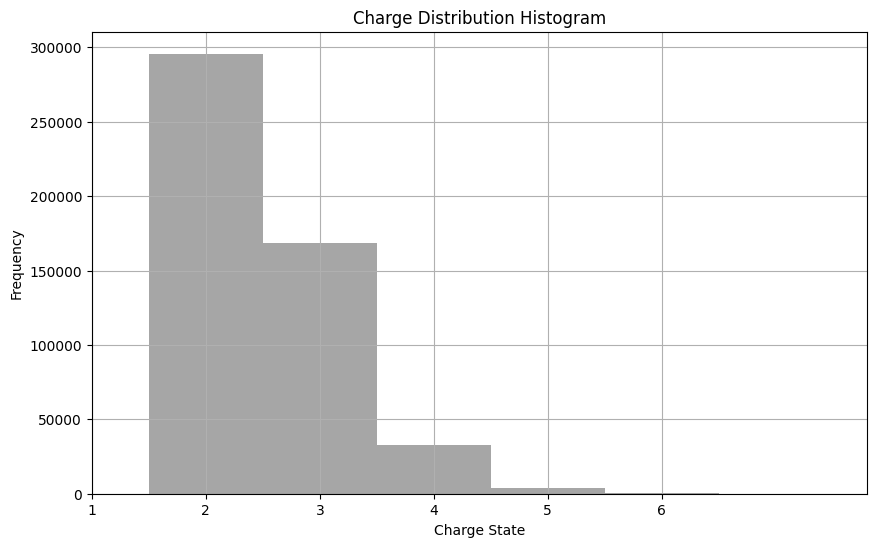

In [12]:
plot_charge_distribution(processed_data, 'charge_by_max_intensity')

## Advanced Baseline Models

This section explores more sophisticated baseline methods like majority baselines and evaluates them against the dataset to determine how a simple model performs relative to random guesses.


In [13]:
def majority_baseline(df, k=1):
    """
    Calculate and print the performance metrics for the majority baseline model.
    This model predicts the most frequent charge state for all entries.
    """
    if 'charge_by_max_intensity' not in df.columns:
        raise ValueError("Define a column with one integer value for the precursor charge")

    charge_counts = df['charge_by_max_intensity'].value_counts()
    top_k_charges = charge_counts.nlargest(k).index.tolist()
    top_charge = top_k_charges[0]
    baseline_predictions = [top_charge] * len(df)
    actual_charges = df['charge_by_max_intensity'].tolist()
    accuracy = accuracy_score(actual_charges, baseline_predictions)
    report = classification_report(actual_charges, baseline_predictions, labels=[top_charge], zero_division=0)

    print(f"majority charge is: {top_charge}")
    print(f"Accuracy of the majority baseline: {accuracy:.2f}")
    print(report)

baseline_metrics = majority_baseline(processed_data, k=1)


majority charge is: 2
Accuracy of the majority baseline: 0.56
              precision    recall  f1-score   support

           2       0.56      1.00      0.72    295679

   micro avg       0.56      1.00      0.72    295679
   macro avg       0.56      1.00      0.72    295679
weighted avg       0.56      1.00      0.72    295679



## Task-specific Dummy Classifiers

In this section, dummy classifiers are tailored for specific tasks to benchmark against more sophisticated models later.


In [14]:
# Task 1: Evaluate charge prediction accuracy using different dummy strategies
def evaluate_dummy_strategies(data, feature_column, target_column, strategies):
    """
    Evaluate various dummy strategies and report their accuracy and classification report.
    """
    for strategy in strategies:
        if strategy == 'constant':
            dummy_clf = DummyClassifier(strategy=strategy, constant=data[target_column].mode()[0])
        else:
            dummy_clf = DummyClassifier(strategy=strategy)
        dummy_clf.fit(data[feature_column].tolist(), data[target_column])
        predictions = dummy_clf.predict(data[feature_column].tolist())
        accuracy = accuracy_score(data[target_column], predictions)
        print(f"Accuracy of the {strategy} baseline: {accuracy:.2f}")

In [15]:
evaluate_dummy_strategies(processed_data, 'encoded_sequences', 'charge_by_max_intensity', strategies)

Accuracy of the most_frequent baseline: 0.56
Accuracy of the stratified baseline: 0.42
Accuracy of the constant baseline: 0.56
Accuracy of the uniform baseline: 0.17


In [16]:
def evaluate_multi_label_classification(data, feature_column, label_column):
    """
    Evaluate the performance of a dummy classifier on multi-label data.
    """
    from sklearn.dummy import DummyClassifier
    from sklearn.metrics import accuracy_score, hamming_loss
    from sklearn.multioutput import MultiOutputClassifier
    import numpy as np  # Make sure numpy is imported if used for operations

    data['more_than_one_charge_state'] = data[label_column].apply(lambda x: np.sum(x) > 1)
    count_more_than_one = data['more_than_one_charge_state'].sum()
    print("Sequences with more than one charge state:", count_more_than_one, 
          "->", count_more_than_one / len(data) * 100, "%")

    X = np.array(data[feature_column].tolist())
    y = np.array(data[label_column].tolist())
    dummy = DummyClassifier(strategy="most_frequent")
    multi_target_dummy = MultiOutputClassifier(dummy, n_jobs=-1)
    multi_target_dummy.fit(X, y)
    y_pred = multi_target_dummy.predict(X)
    accuracy = accuracy_score(y, y_pred)
    hamming = hamming_loss(y, y_pred)
    print(f"Accuracy of the multi-label dummy classifier: {accuracy:.2f}")
    print(f"Hamming loss of the multi-label dummy classifier: {hamming:.2f}")


In [17]:
evaluate_multi_label_classification(processed_data, 'encoded_sequences', 'charge_state_vector')

Sequences with more than one charge state: 209133 -> 39.52879135833971 %
Accuracy of the multi-label dummy classifier: 0.44
Hamming loss of the multi-label dummy classifier: 0.14


## Regression Baselines for Continuous Outcomes

This section introduces a regression baseline using a `DummyRegressor` to predict continuous charge distributions.


In [18]:
def evaluate_regression_baseline(data, feature_column, target_column):
    """
    Evaluate the performance of a regression baseline model.
    """
    from sklearn.dummy import DummyRegressor
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    X = np.stack(data[feature_column].values)
    y = data[target_column].values
    dummy_regressor = DummyRegressor(strategy="mean")
    dummy_regressor.fit(X, y)
    y_pred = dummy_regressor.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    print(f"MSE of the mean baseline: {mse:.2f}")
    print(f"MAE of the mean baseline: {mae:.2f}")


In [19]:
processed_data['charge_distribution'] = np.random.rand(len(processed_data))  # Creating a dummy charge_distribution column
evaluate_regression_baseline(processed_data, 'encoded_sequences', 'charge_distribution')

MSE of the mean baseline: 0.08
MAE of the mean baseline: 0.25


## Visualization of Prediction Results

The final sections visualize the prediction accuracy using histograms and confusion matrices to provide visual insights into the model performance.


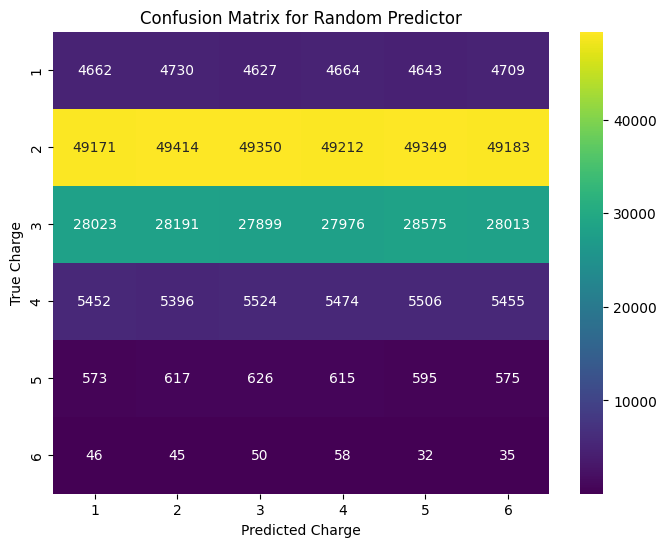

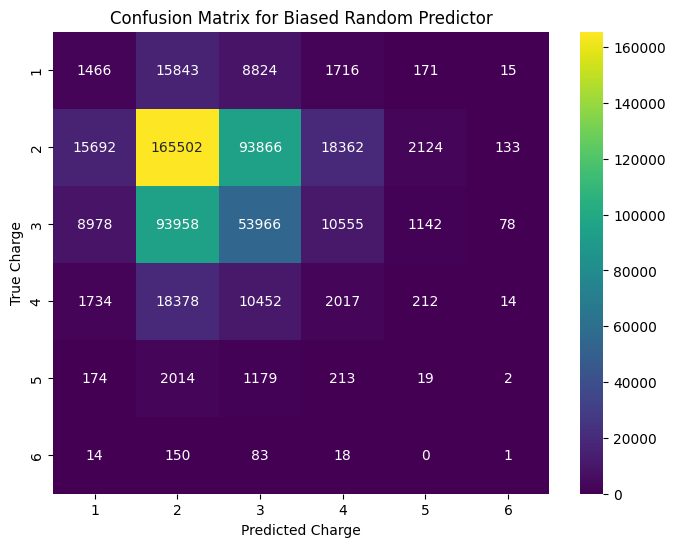

In [20]:
def plot_confusion_matrix(data, true_column, predicted_column, title):
    """
    Plot a confusion matrix to visualize the accuracy of predictions.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    conf_matrix = confusion_matrix(data[true_column], data[predicted_column])
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=np.unique(data[true_column]), yticklabels=np.unique(data[true_column]))
    plt.title(title)
    plt.xlabel('Predicted Charge')
    plt.ylabel('True Charge')
    plt.show()

plot_confusion_matrix(processed_data, 'charge_by_max_intensity', 'random_prediction', 'Confusion Matrix for Random Predictor')
plot_confusion_matrix(processed_data, 'charge_by_max_intensity', 'biased_random_prediction', 'Confusion Matrix for Biased Random Predictor')
